## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt 
from IPython.display import clear_output

from random import sample
from tqdm import tqdm

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
np.sum([len(x) for x in text])

100225

In [4]:
# check the set of last characters in sentences

np.unique([x[-1] for x in text])

array(['\n'], dtype='<U1')

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# text = ''.join([x.lower() for x in text])

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2023-01-02 11:00:51--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2023-01-02 11:00:52 (59.4 MB/s) - ‘onegin.txt’ saved [262521/262521]



### Work with data

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
text[10:20]

['  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding:\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '\n',
 '  II\n',
 '\n',
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n"]

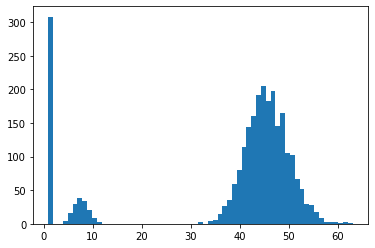

In [7]:
# check lengths of lines
# a bin for each length of line
# (1 + max_length) bins

bins = np.max([len(line) for line in text])
plt.hist([len(line) for line in text], bins=bins);

In [8]:
len([x for x in text if 1 < len(x) < 15]), \
len([x for x in text if 1 < len(x) < 30])

(153, 153)

In [9]:
print([x for x in text if 1 < len(x) < 15])

['  II\n', '  III\n', '  IV\n', '  V\n', '  VI\n', '  VII\n', '  VIII\n', '  IX\n', '  X\n', '  XI\n', '  XII\n', '  XIII\n', '  XIV\n', '  XV\n', '  XVI\n', '  XVII\n', '  XVIII\n', '  XIX\n', '  XX\n', '  XXI\n', '  XXII\n', '  XXIII\n', '  XXIV\n', '  XXV\n', '  XXVI\n', '  XXVII\n', '  XXVIII\n', '  XXIX\n', '  XXX\n', '  XXXI\n', '  XXXII\n', '  XXXIII\n', '  XXXIV\n', '  XXXV\n', '  XXXVI\n', '  XXXVII\n', '  XXXVIII\n', '  XXXIX\n', '  XL\n', '  XLI\n', '  XLII\n', '  XLIII\n', '  XLIV\n', '  XLV\n', '  XLVI\n', '  XLVII\n', '  XLVIII\n', '  XLIX\n', '  L\n', '  LI\n', '  LII\n', '  LIII\n', '  LIV\n', '  LV\n', '  LVI\n', '  LVII\n', '  LVIII\n', '  LIX\n', '  LX\n', '  LXI\n', '  LXII\n', '  LXIII\n', '  LXIV\n', '  LXV\n', '  LXVI\n', '  LXVII\n', '  LXVIII\n', '  LXIX\n', '  LXX\n', '  LXXI\n', '  LXXII\n', '  LXXIII\n', '  LXXIV\n', '  LXXV\n', '  LXXVI\n', '  LXXVII\n', '  LXXVIII\n', '  LXXIX\n', '  LXXX\n', '  LXXXI\n', '  LXXXII\n', '  LXXXIII\n', '  LXXXIV\n', '  LXXXV

In [10]:
np.all([x == '\n' for x in text if len(x) == 1])

True

It seems to be a good idea to delete all lines == '\n' and wich have less than 30 characters.

len(text) = 2616
len(text) = 2155


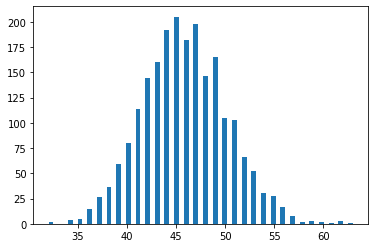

In [11]:
print('len(text) =', len(text))
text = [x for x in text if len(x) >= 30]
print('len(text) =', len(text))

bins = np.max([len(line) for line in text])
plt.hist([len(line) for line in text], bins=bins);

In [12]:
text[10:20]

['  Within thine own bud buriest thy content,\n',
 "  And tender churl mak'st waste in niggarding:\n",
 '    Pity the world, or else this glutton be,\n',
 "    To eat the world's due, by the grave and thee.\n",
 '  When forty winters shall besiege thy brow,\n',
 "  And dig deep trenches in thy beauty's field,\n",
 "  Thy youth's proud livery so gazed on now,\n",
 "  Will be a tatter'd weed of small worth held:\n",
 '  Then being asked, where all thy beauty lies,\n',
 '  Where all the treasure of thy lusty days;\n']

In [13]:
# every line now has whitespace and '\n' at the end
# strip lines, but leave '\n' at the end of them

len([x for x in text if x[0] == ' ']), \
len([x for x in text if x[-1] == '\n'])

(2155, 2155)

In [14]:
text = [x.strip() + "\n" for x in text]
text[10:20]

['Within thine own bud buriest thy content,\n',
 "And tender churl mak'st waste in niggarding:\n",
 'Pity the world, or else this glutton be,\n',
 "To eat the world's due, by the grave and thee.\n",
 'When forty winters shall besiege thy brow,\n',
 "And dig deep trenches in thy beauty's field,\n",
 "Thy youth's proud livery so gazed on now,\n",
 "Will be a tatter'd weed of small worth held:\n",
 'Then being asked, where all thy beauty lies,\n',
 'Where all the treasure of thy lusty days;\n']

In [15]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# lowercase all symbols in all sentences
text = [x.lower() for x in text]
text[10:20]

['within thine own bud buriest thy content,\n',
 "and tender churl mak'st waste in niggarding:\n",
 'pity the world, or else this glutton be,\n',
 "to eat the world's due, by the grave and thee.\n",
 'when forty winters shall besiege thy brow,\n',
 "and dig deep trenches in thy beauty's field,\n",
 "thy youth's proud livery so gazed on now,\n",
 "will be a tatter'd weed of small worth held:\n",
 'then being asked, where all thy beauty lies,\n',
 'where all the treasure of thy lusty days;\n']

In [16]:
# clean text from any punctuation

for i in range(len(text)):
    for c in string.punctuation:
        text[i] = text[i].translate({ord(c): None})

text[10:20]

['within thine own bud buriest thy content\n',
 'and tender churl makst waste in niggarding\n',
 'pity the world or else this glutton be\n',
 'to eat the worlds due by the grave and thee\n',
 'when forty winters shall besiege thy brow\n',
 'and dig deep trenches in thy beautys field\n',
 'thy youths proud livery so gazed on now\n',
 'will be a tatterd weed of small worth held\n',
 'then being asked where all thy beauty lies\n',
 'where all the treasure of thy lusty days\n']

In [17]:
string.digits

'0123456789'

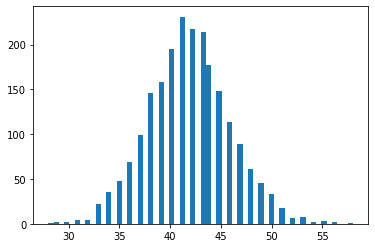

In [18]:
bins = np.max([len(line) for line in text])
plt.hist([len(line) for line in text], bins=bins);

In [21]:
# if lines with very different lengths like 30, 40, 45, 50 happen in same batch
# there are some problems with padding: too many pad tokens is placed in it
# the possible solution is to move some characters from one line to previuos or next
# such transformation will do our data more similar

def make_lines_similar_length(batch):
    equal = True
    for line in batch[1:]:
        if len(line) != len(batch[0]):
            equal = False
            break
    if equal:
        return

    full_text = "".join(batch)
    cnt_chars = len(full_text)
    avg_len = cnt_chars // len(batch)
    if cnt_chars % len(batch) > 0:
        avg_len += 1
    for i in range(len(batch)):
        batch[i] = full_text[i * avg_len : (i+1) * avg_len]

In [22]:
tmp = [
    'abc',
    'hkl',
    'npo'
]

make_lines_similar_length(tmp)
tmp

['abc', 'hkl', 'npo']

In [23]:
tmp = [
    'abcdefg',
    'hklm',
    'npo'
]

make_lines_similar_length(tmp)
tmp

['abcde', 'fghkl', 'mnpo']

Put all the characters, that you've seen in the text, into variable `tokens`.

In [24]:
# tokens = sorted(set(out))

tokens = set()

for x in text:
    tokens.update(set(x))

print(len(tokens))
print(tokens)

28
{'f', 'x', 'h', 's', '\n', 'w', 'u', 'y', 'o', 'm', 'd', ' ', 'k', 'r', 'q', 'e', 'c', 'j', 'l', 'v', 'i', 'z', 'b', 'a', 'g', 'p', 'n', 't'}


In [25]:
'_' in tokens

False

In [26]:
PAD = '_'
tokens.add(PAD)
tokens = sorted(list(tokens))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [27]:
id_to_token = {i: x for i, x in enumerate(tokens)}
token_to_id = {x: i for i, x in enumerate(tokens)}

In [28]:
print(tokens)

['\n', ' ', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
print([x for x in tokens if x not in {chr(c) for c in range(ord('a'), 1 + ord('z'))}])

['\n', ' ', '_']


In [30]:
len(tokens)

29

In [31]:
# dict <index>:<char>
# Your great code here
# id_to_token = {i: x for i, x in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
# token_to_id = {x: i for i, x in enumerate(tokens)}

In [32]:
assert np.all(x == id_to_token[token_to_id[x]]  for x in token_to_id)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [33]:
# here we form batch from several lines

def to_matrix(
        lines, max_len=None, pad=token_to_id['_'], dtype='int32', batch_first=True
    ):
    """Casts a list of lines into rnn-digestable matrix"""

    max_len = max_len or max(map(len, lines))
    names_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        names_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [34]:
token_to_id['_']

2

In [35]:
to_matrix(text[:3])

array([[ 8, 20, 17, 15,  1,  8,  3, 11, 20,  7, 21, 22,  1,  5, 20,  7,
         3, 22, 23, 20,  7, 21,  1, 25,  7,  1,  6,  7, 21, 11, 20,  7,
         1, 11, 16,  5, 20,  7,  3, 21,  7,  0],
       [22, 10,  3, 22,  1, 22, 10,  7, 20,  7,  4, 27,  1,  4,  7,  3,
        23, 22, 27, 21,  1, 20, 17, 21,  7,  1, 15, 11,  9, 10, 22,  1,
        16,  7, 24,  7, 20,  1,  6, 11,  7,  0],
       [ 4, 23, 22,  1,  3, 21,  1, 22, 10,  7,  1, 20, 11, 18,  7, 20,
         1, 21, 10, 17, 23, 14,  6,  1,  4, 27,  1, 22, 11, 15,  7,  1,
         6,  7,  5,  7,  3, 21,  7,  0,  2,  2]], dtype=int32)

In [36]:
num_tokens = len(tokens)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_tokens, device

(29, device(type='cuda'))

In [37]:
len(text)
text[10:20]

['within thine own bud buriest thy content\n',
 'and tender churl makst waste in niggarding\n',
 'pity the world or else this glutton be\n',
 'to eat the worlds due by the grave and thee\n',
 'when forty winters shall besiege thy brow\n',
 'and dig deep trenches in thy beautys field\n',
 'thy youths proud livery so gazed on now\n',
 'will be a tatterd weed of small worth held\n',
 'then being asked where all thy beauty lies\n',
 'where all the treasure of thy lusty days\n']

In [41]:
# text = "\n".join(text)
# text
MAX_PHRASE = 100

full_text = "\n".join(text)
new_text = [full_text[i:i+MAX_PHRASE] for i in range(len(full_text) - MAX_PHRASE)]

In [43]:
len(new_text), len(new_text[0])

(92302, 100)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [46]:
MAX_EPOCHS = 100
batch_size = 64

# important : read lines 1 by 1, not randomly (order of words is important)

def train_model(model, text, loss_func, opt, epochs=100, lr_sched=None):

    pbar = tqdm(range(epochs), desc='Total')
    history = []
    states = model.initial_state(batch_size)

    for i in pbar:
        epoch_loss = []
        for bi in range(0, len(text), batch_size):
            # batch = np.random.choice(text, size=batch_size)
            batch = text[bi:bi+batch_size]
            if len(batch) != batch_size:
                continue
            # print('batch shape:', len(batch), len(batch[0]))
            make_lines_similar_length(batch)
            # print('batch shape:', len(batch), len(batch[0]))
            # batch_ix = [token_to_id[c] for c in batch]
            batch_ix = to_matrix(batch)
            batch_ix = torch.LongTensor(batch_ix)
            
            batch_ix = batch_ix.to(device)
            states = states.to(device)

            logits_seq, states = model(batch_ix, states)
            states = states.detach()

            predictions_logits = logits_seq[:-1]
            actual_next_tokens = batch_ix[1:]

            loss = loss_func(
                predictions_logits.reshape((-1, num_tokens)),
                actual_next_tokens.reshape(-1)
            )
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_loss.append(loss.item())
        
        if lr_sched is not None:
            lr_sched.step(loss)
        
        history.append(np.mean(epoch_loss))
        if (i + 1) % 5 == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."
    return history

In [47]:
# Your code here

class MyModelRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states):
        # assert isinstance(x.data, torch.LongTensor), type(x)
        h_seq, next_states = self.rnn(self.emb(x), states)
        next_logits = self.hid_to_logits(h_seq)
        # next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logits, next_states # next_logp
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=False)

In [48]:
device

device(type='cuda')

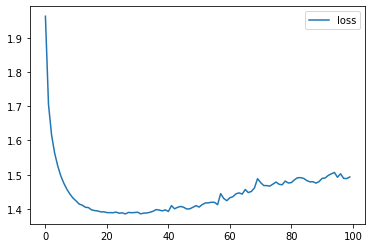

Total: 100%|██████████| 100/100 [10:34<00:00,  6.35s/it]


In [49]:
model_rnn = MyModelRNN(emb_size=64, rnn_num_units=256)
model_rnn = model_rnn.to(device)
opt_rnn = torch.optim.Adam(model_rnn.parameters()) #, lr=3e-2)
# lr_shed = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt_rnn, factor=0.7, threshold=5e-2)
# lr_shed.last_epoch = 160
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])

history_rnn = train_model(model_rnn, new_text, loss_func, opt=opt_rnn, epochs=100, lr_sched=None)

In [50]:
MAX_LENGTH = 70

def generate_text(model, seed_phrase='hello, ', max_length=MAX_LENGTH, temperature=1.0):
    seq = [token_to_id[token] for token in seed_phrase]
    phrase = torch.LongTensor(seq)
    seq = torch.LongTensor([seq])
    seq = seq.to(device)

    states = model.initial_state(1)    
    states = states.to(device)
    logits_seq, states = model(seq, states)
    logits_next = logits_seq[-1]
    
    softmax = nn.Softmax()

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        
        p_next = softmax(logits_next / temperature)[-1]
        # print('p_next.shape =', p_next.shape)
        
        next_token = np.random.choice(len(tokens), p=p_next.cpu().detach().numpy())
        phrase = torch.cat([phrase, torch.tensor([next_token])])
        next_token = [[next_token]]
        next_token = torch.LongTensor(next_token)
        next_token = next_token.to(device)
        
        logits_seq, states = model(next_token, states)  # <-- here we call your one-step code
        logits_next = logits_seq[-1]
        
    return ''.join([tokens[ix] for ix in phrase]) #.data.numpy()[0]])

In [51]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f't = {t}, text:')
    print(generate_text(model_rnn, seed_phrase='hello m', max_length=50, temperature=t) + '\n')

# print(f't = {0.1}, text:', generate_sample(char_rnn, seed_phrase='hello, m', max_length=50, temperature=0.1))

t = 0.1, text:
hello my heart thee a frown and thee a madience an

t = 0.2, text:
hello my heart the but thee hate thee a hate do be

t = 0.5, text:
hello my verjurious love grown fair by thy fair of

t = 1.0, text:
hello my divides victhray

and forgace i love thee

t = 2.0, text:
hello mariut toughakd net dodpeing fow greinousiff



<ipython-input-50-eb936eabeb2d>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p_next = softmax(logits_next / temperature)[-1]


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

My latest idea: use states in forward(), they keep some usefull information.

In [60]:
MAX_EPOCHS = 100
batch_size = 64

# important : read lines 1 by 1, not randomly (order of words is important)

def train_model_lstm(model, text, loss_func, opt, epochs=100, lr_sched=None, batch_size=64):

    pbar = tqdm(range(epochs), desc='Total')
    history = []
    h, c = model.initial_state(batch_size)

    for i in pbar:
        epoch_loss = []
        for bi in range(0, len(text), batch_size):
            # batch = np.random.choice(text, size=batch_size)
            batch = text[bi:bi+batch_size]
            if len(batch) != batch_size:
                continue
            # print('batch shape:', len(batch), len(batch[0]))
            make_lines_similar_length(batch)
            # print('batch shape:', len(batch), len(batch[0]))
            # batch_ix = [token_to_id[c] for c in batch]
            batch_ix = to_matrix(batch)
            batch_ix = torch.LongTensor(batch_ix)
            
            batch_ix = batch_ix.to(device)
            h = h.to(device)
            c = c.to(device)

            logits_seq, (h, c) = model(batch_ix, (h, c))
            h = h.detach()
            c = c.detach()

            predictions_logits = logits_seq[:-1]
            actual_next_tokens = batch_ix[1:]

            loss = loss_func(
                predictions_logits.reshape((-1, num_tokens)),
                actual_next_tokens.reshape(-1)
            )
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_loss.append(loss.item())
        
        if lr_sched is not None:
            lr_sched.step(loss)
        
        history.append(np.mean(epoch_loss))
        if (i + 1) % 5 == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."
    return history

In [57]:
class MyModelLSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, state_seq=None):
        # assert isinstance(x.data, torch.LongTensor), type(x)
        if state_seq is None:
            state_seq = self.initial_state()
        h_seq, state_seq = self.rnn(self.emb(x), state_seq)
        next_logits = self.hid_to_logits(h_seq)
        # next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logits, state_seq # next_logp
    
    def initial_state(self, batch_size):
        h = c = torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
        init_state = (h, c)
        return init_state

In [54]:
device

device(type='cuda')

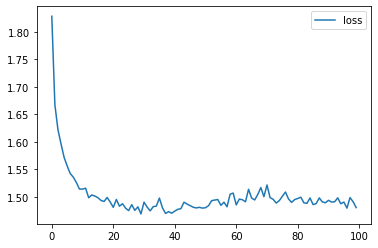

Total: 100%|██████████| 100/100 [22:43<00:00, 13.63s/it]


In [58]:
# device = 'cuda:0'
model_lstm = MyModelLSTM(emb_size=64, rnn_num_units=256)
model_lstm = model_lstm.to(device)
opt_lstm = torch.optim.Adam(model_lstm.parameters(), lr=8e-3)
lr_shed = torch.optim.lr_scheduler.StepLR(
    opt_lstm, step_size=100, gamma=0.7
)
# lr_shed_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt_lstm, factor=0.7, threshold=5e-2)
# lr_shed_lstm.last_epoch = 160
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])

# history_lstm = []
history_lstm = train_model_lstm(model_lstm, new_text, loss_func, opt=opt_lstm, epochs=100, lr_sched=lr_shed)

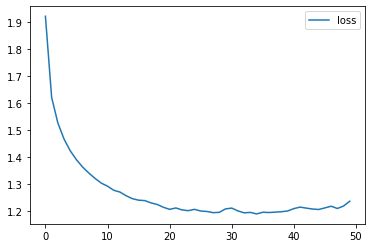

Total: 100%|██████████| 50/50 [07:02<00:00,  8.44s/it]


In [62]:
# device = 'cuda:0'
model_lstm_small = MyModelLSTM(emb_size=48, rnn_num_units=196)
model_lstm_small = model_lstm_small.to(device)
opt_lstm_small = torch.optim.Adam(model_lstm_small.parameters(), lr=5e-3)
lr_shed_small = torch.optim.lr_scheduler.StepLR(
    opt_lstm_small, step_size=150, gamma=0.8
)
# lr_shed_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt_lstm, factor=0.7, threshold=5e-2)
# lr_shed_lstm.last_epoch = 160
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])

# history_lstm = []
history_lstm_small = train_model_lstm(
    model_lstm_small, new_text, loss_func, opt=opt_lstm_small, lr_sched=lr_shed_small,
    epochs=50, batch_size=256
)

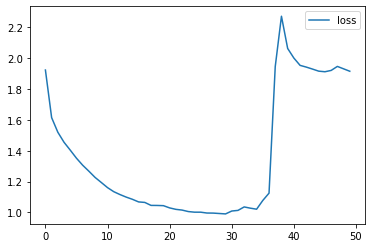

Total: 100%|██████████| 50/50 [21:57<00:00, 26.35s/it]


AssertionError: ignored

In [63]:
# device = 'cuda:0'
model_lstm_big = MyModelLSTM(emb_size=128, rnn_num_units=512)
model_lstm_big = model_lstm_big.to(device)
opt_lstm_big = torch.optim.Adam(model_lstm_big.parameters(), lr=5e-3)

# opt_lstm_big = torch.optim.Adam(model_lstm_big.parameters(), lr=8e-3)
# lr_shed_big = torch.optim.lr_scheduler.StepLR(
#     opt_lstm_big, step_size=150, gamma=0.8
# )

lr_shed_big=None
# lr_shed_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt_lstm, factor=0.7, threshold=5e-2)
# lr_shed_lstm.last_epoch = 160
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])

# history_lstm = []
history_lstm_big = train_model_lstm(
    model_lstm_big, new_text, loss_func, opt=opt_lstm_big, lr_sched=lr_shed_big,
    epochs=50, batch_size=512
)

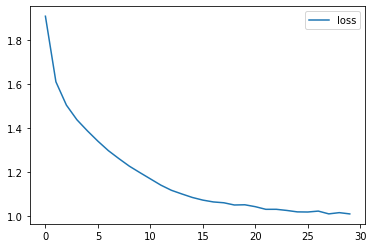

Total: 100%|██████████| 30/30 [13:08<00:00, 26.29s/it]


In [64]:
# device = 'cuda:0'
model_lstm_big = MyModelLSTM(emb_size=128, rnn_num_units=512)
model_lstm_big = model_lstm_big.to(device)
opt_lstm_big = torch.optim.Adam(model_lstm_big.parameters(), lr=5e-3)

# opt_lstm_big = torch.optim.Adam(model_lstm_big.parameters(), lr=8e-3)
# lr_shed_big = torch.optim.lr_scheduler.StepLR(
#     opt_lstm_big, step_size=150, gamma=0.8
# )

lr_shed_big=None
# lr_shed_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt_lstm, factor=0.7, threshold=5e-2)
# lr_shed_lstm.last_epoch = 160
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_id['_'])

# history_lstm = []
history_lstm_big = train_model_lstm(
    model_lstm_big, new_text, loss_func, opt=opt_lstm_big, lr_sched=lr_shed_big,
    epochs=30, batch_size=512
)

In [65]:
history_lstm_big[-1]

1.008577084541321

Plot the loss function of the number of epochs. Does the final loss become better?

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [66]:
MAX_LENGTH = 200

def generate_text_lstm(model, seed_phrase='hello, ', max_length=MAX_LENGTH, temperature=1.0):
    seq = [token_to_id[token] for token in seed_phrase]
    phrase = torch.LongTensor(seq)
    seq = torch.LongTensor([seq])
    seq = seq.to(device)

    h, c = model.initial_state(1)    
    h, c = h.to(device), c.to(device)
    logits_seq, (h, c) = model(seq, (h, c))
    logits_next = logits_seq[-1]
    
    softmax = nn.Softmax()

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        
        p_next = softmax(logits_next / temperature)[-1]
        # print('p_next.shape =', p_next.shape)
        
        next_token = np.random.choice(len(tokens), p=p_next.cpu().detach().numpy())
        phrase = torch.cat([phrase, torch.tensor([next_token])])
        next_token = [[next_token]]
        next_token = torch.LongTensor(next_token)
        next_token = next_token.to(device)
        
        logits_seq, (h, c) = model(next_token, (h, c))  # <-- here we call your one-step code
        logits_next = logits_seq[-1]
        
    return ''.join([tokens[ix] for ix in phrase]) #.data.numpy()[0]])

In [71]:
# compare 3 lstm models above
# from warnings import filterwarnings

# filterwarnings(action='ignore')

print('small_lstm, t = 0.1, text:')
print(generate_text_lstm(model_lstm_small, seed_phrase='the day', max_length=200, temperature=0.1))
print()

print('lstm, t = 0.1, text:')
print(generate_text_lstm(model_lstm, seed_phrase='the day', max_length=200, temperature=0.1))
print()

print('big_lstm, t = 0.1, text:')
print(generate_text_lstm(model_lstm_big, seed_phrase='the day', max_length=200, temperature=0.1))
print()

small_lstm, t = 0.1, text:
the day of thee doth see

who to my self are me in my sight

and they see the world i say this shall state

and they see the world thee and they see

which in thy sweet by and they see

which in thy s

lstm, t = 0.1, text:
the day

and thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee

the swear thee thee thee thee thee thee thee thee thee thee thee t

big_lstm, t = 0.1, text:
the day

when i have sworn thee thou be death the day

when i have sworn thee thou art cruel do not love to be

the sea all my love that thou dost love thee so bold

that he that i am a fortune me do 



In [74]:
# Text generation with different temperature values here

for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(
        f't = {t}, text:', 
        generate_text_lstm(model_lstm_small, seed_phrase='why', max_length=70, temperature=t) + '\n\n'
    )

t = 0.1, text: why should i do content

thou art the world i should i do content

tha


t = 0.2, text: why should i do content

which i thy proud of thy dear love to my self


t = 0.5, text: why should for my soul and i do call

though i neerce to myself as it 


t = 1.0, text: why grose well

ill i love herding her slaid my lovers eye in the wron


t = 2.0, text: why see
bairfrursefs

thats no mo cays

ay from thxesest thee achinks 




In [88]:
# Text generation with different temperature values here

for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(
        f't = {t}, text:', 
        generate_text_lstm(model_lstm_small, seed_phrase='oh ', max_length=70, temperature=t) + '\n\n'
    )

t = 0.1, text: oh the sad

the fair assurd in thy self thee are death doth see

who t


t = 0.2, text: oh my state

and thou dost thou thy self are me thee

who in the world


t = 0.5, text: oh false and the fair newer from dear delight

than thou gavst my sinf


t = 1.0, text: oh my mind doubdes fair

my slafces

be as not men be thy basterving t


t = 2.0, text: oh dost besel
oussivicioughpay on thee replated

sleen it feure eterss




### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [90]:
# Saving and loading code here

path = 'saved_model_state_dict.pt'

torch.save(model_lstm_small.state_dict(), path)

# model_lstm_small = MyModelLSTM(emb_size=48, rnn_num_units=196)

new_model_lstm_small = MyModelLSTM(emb_size=48, rnn_num_units=196)
new_model_lstm_small.load_state_dict(torch.load(path))
new_model_lstm_small = new_model_lstm_small.to(device)

print(generate_text_lstm(
    new_model_lstm_small, seed_phrase='hello', max_length=200, temperature=0.01
))

hellowd that i do change

and thou thy self thou thy sweet self defence

that i am of thy sinful earth thee are death doth see

who leaves on the fair as thou dost thou thy sinful stays are death doth


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)